# **Define of Model**

In [7]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
def al_salam_carlitz(n, x, a, q):
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x - a
    else:
        return (x - (a + q**n)) * al_salam_carlitz(n-1, x, a, q) - a * q**(n-1) * al_salam_carlitz(n-2, x, a, q)

class AlSalamCarlitzKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree, a_init=None, q_init=None):
        super(AlSalamCarlitzKANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree

        if a_init is None:
            a_init = torch.zeros(1)
        if q_init is None:
            q_init = torch.ones(1)

        self.a = nn.Parameter(a_init)
        self.q = nn.Parameter(q_init)

        self.al_salam_carlitz_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.al_salam_carlitz_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        # Normalize x to [-1, 1] using tanh
        x = torch.tanh(x)

        # Compute the Al-Salam-Carlitz basis functions
        al_salam_carlitz_basis = []
        for n in range(self.degree + 1):
            al_salam_carlitz_basis.append(al_salam_carlitz(n, x, self.a, self.q))
        al_salam_carlitz_basis = torch.stack(al_salam_carlitz_basis, dim=-1)  # shape = (batch_size, input_dim, degree + 1)

        # Compute the Al-Salam-Carlitz interpolation
        y = torch.einsum("bid,iod->bo", al_salam_carlitz_basis, self.al_salam_carlitz_coeffs)  # shape = (batch_size, output_dim)
        y = y.view(-1, self.output_dim)

        return y

class MNISTAlSalamCarlitzKAN(nn.Module):
    def __init__(self):
        super(MNISTAlSalamCarlitzKAN, self).__init__()
        self.trigkan1 = AlSalamCarlitzKANLayer(784, 32, 3)
        self.bn1 = nn.LayerNorm(32)
        self.trigkan2 = AlSalamCarlitzKANLayer(32, 32, 3)
        self.bn2 = nn.LayerNorm(32)
        self.trigkan3 = AlSalamCarlitzKANLayer(32, 10, 3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x=x.tanh()
        x = self.trigkan1(x)
        x = self.bn1(x)
        x = self.trigkan2(x)
        x = self.bn2(x)
        x = self.trigkan3(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as n
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10



criterion = nn.CrossEntropyLoss()


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

In [5]:
Model_Names=['AlSalam-Carlitz'] #Add names of other models
model0 = MNISTAlSalamCarlitzKAN().to(device)
models=[model0]
total_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
print(f"Total trainable parameters of {Model_Names[0]}: {total_params}")


Total trainable parameters of AlSalam-Carlitz: 105862


# **Training of Model**

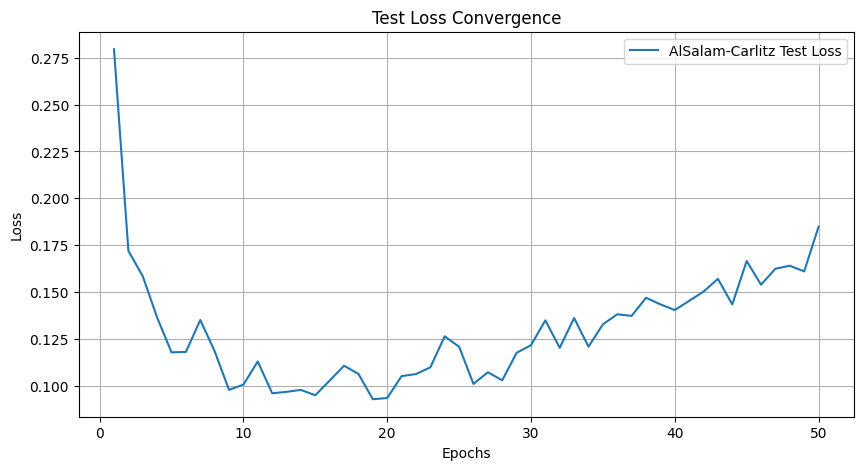

AlSalam-Carlitz processing time: 927.30 seconds


In [8]:
import time

epochs = 50

def train_and_validate(models, model_names, train_loader, test_loader, criterion, optimizers, device, epochs):
    train_losses = [[] for _ in range(len(models))]
    test_losses = [[] for _ in range(len(models))]
    best_weights = [None] * len(models)
    best_test_losses = [float('inf')] * len(models)
    model_times = [0.0] * len(models)  # Initialize a list to store processing time for each model

    for epoch in range(epochs):
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            start_time = time.time()  # Record the start time

            train_loss = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_accuracy = validate(model, test_loader, criterion, device)

            end_time = time.time()  # Record the end time
            model_times[i] += end_time - start_time  # Accumulate the processing time for the current model

            train_losses[i].append(train_loss)
            test_losses[i].append(test_loss)

            if test_loss < best_test_losses[i]:
                best_test_losses[i] = test_loss
                best_weights[i] = model.state_dict()

            print(f'{model_names[i]}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

    return train_losses, test_losses, best_weights, model_times


optimizers = [optim.Adam(model.parameters(), lr=0.0002) for model in models]

train_losses, test_losses, best_weights, model_times = train_and_validate(models, Model_Names, train_loader, test_loader, criterion, optimizers, device, epochs)

plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(range(1, epochs + 1), test_losses[i], label=f'{Model_Names[i]} Test Loss')
plt.title('Test Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the best weights for each model
for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    torch.save(model.state_dict(), f'{Model_Names[i]}_best_weights.pth')

# Print the processing time for each model
for i, model_name in enumerate(Model_Names):
    print(f"{model_name} processing time: {model_times[i]:.2f} seconds")

# **Model Test**

In [9]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    test_labels=[]

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
    return predictions,test_labels


In [10]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
metrics = {
    'Accuracy': [],
    'Kappa': [],
    'F1 Score': []
}

for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    model.eval()

    test_preds,test_labels = predict(model, test_loader, device)
    f1 = f1_score(test_labels, test_preds, average='micro')
    kappa = cohen_kappa_score(test_labels, test_preds)
    overall_acc = accuracy_score(test_labels, test_preds)
    metrics['Accuracy'].append(overall_acc)
    metrics['Kappa'].append(kappa)
    metrics['F1 Score'].append(f1)
    
    print(f"Model {Model_Names[i]} - "
          f"Overall Accuracy: {overall_acc:.4f}, "
          f"Kappa: {kappa:.4f}, "
          f"F1 Score: {f1:.4f}")

Model AlSalam-Carlitz - Overall Accuracy: 0.9675, Kappa: 0.9639, F1 Score: 0.9675


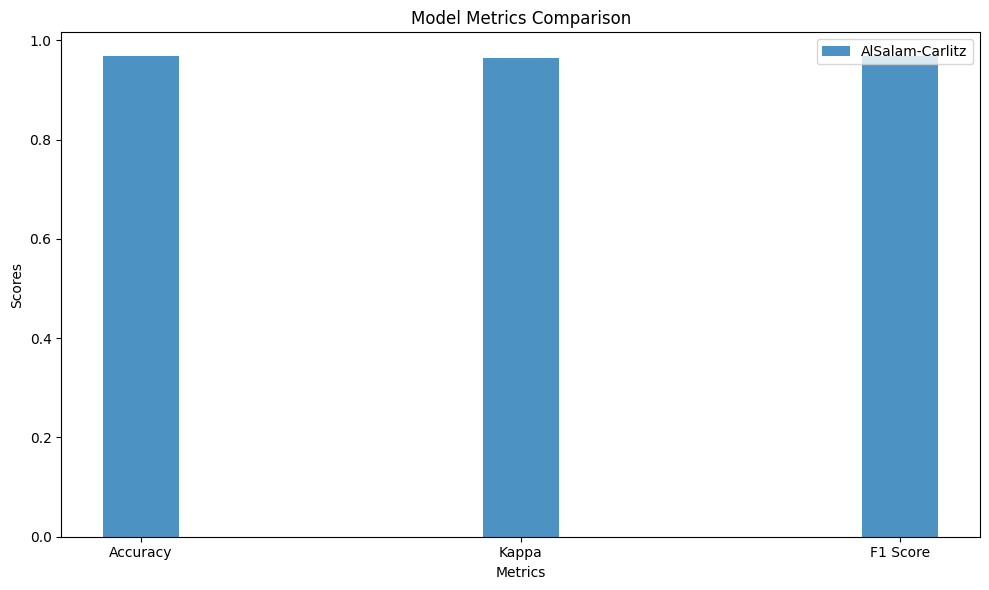

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics.keys()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each model

for i, model_name in enumerate(Model_Names):
    model_metrics = [metrics['Accuracy'][i], metrics['Kappa'][i], metrics['F1 Score'][i]]
    ax.bar(index + i * bar_width, model_metrics, bar_width,
           alpha=opacity, color=colors[i], label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(index + bar_width * (len(Model_Names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()